# Atelier 

<h3 style="color:red;"> 1</h3>


In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os

In [3]:
def trap_mf(x, a, b, c, d):

    x = np.asarray(x, dtype=float)
    y = np.zeros_like(x, dtype=float)
    rising = (x >= a) & (x < b)
    if b > a:
        y[rising] = (x[rising] - a) / (b - a)
    top = (x >= b) & (x <= c)
    y[top] = 1.0
    falling = (x > c) & (x <= d)
    if d > c:
        y[falling] = (d - x[falling]) / (d - c)
    return y


In [4]:
def tri_mf(x, a, b, c):
    return trap_mf(x, a, b, b, c)

In [5]:
def temp_basse(x):
    return tri_mf(x, 0, 0, 40)   

def temp_normale(x):
    return tri_mf(x, 30, 50, 70) 

def temp_elevee(x):
    return tri_mf(x, 60, 100, 100) #


In [6]:
def vib_faible(x):
    return tri_mf(x, 0, 0, 4)

def vib_moyenne(x):
    return tri_mf(x, 2, 5, 8)

def vib_forte(x):
    return tri_mf(x, 6, 10, 10)

In [7]:
def age_neuf(x):
    return tri_mf(x, 0, 0, 7)

def age_moyen(x):
    return tri_mf(x, 5, 10, 15)

def age_ancien(x):
    return tri_mf(x, 12, 20, 20)

In [8]:
risk_x = np.linspace(0, 10, 501)

def risk_faible_mf(x):
    return tri_mf(x, 0, 0, 4)

def risk_moyen_mf(x):
    return tri_mf(x, 2, 5, 8)

def risk_eleve_mf(x):
    return tri_mf(x, 6, 10, 10)

<h3 style="color:red">2:</h3>


* Règles données (représentent le raisonnement expert) :

-R1: Si la température est élevée OU la vibration est forte, alors le risque est élevé.

-R2: Si la machine est ancienne ET la vibration est moyenne, alors le risque est moyen.

-R3: Si la température est basse ET la vibration est faible ET l'âge est neuf, alors risque faible.

-R4: Si la température est normale ET l'âge est moyen, alors risque moyen.


<h3 style="color:red">3:</h3>


In [ ]:
def fuzzy_inference_single(temp, vib, age, debug=False):
    
    t_b = float(temp_basse(np.array([temp]))[0])
    t_n = float(temp_normale(np.array([temp]))[0])
    t_e = float(temp_elevee(np.array([temp]))[0])

    v_f = float(vib_faible(np.array([vib]))[0])
    v_m = float(vib_moyenne(np.array([vib]))[0])
    v_e = float(vib_forte(np.array([vib]))[0])

    a_n = float(age_neuf(np.array([age]))[0])
    a_m = float(age_moyen(np.array([age]))[0])
    a_o = float(age_ancien(np.array([age]))[0])

   
    r1 = max(t_e, v_e)                 
    r2 = min(a_o, v_m)                 
    r3 = min(t_b, v_f, a_n)            
    r4 = min(t_n, a_m)                 
    agg = np.zeros_like(risk_x)
    agg = np.maximum(agg, np.minimum(r1, risk_eleve_mf(risk_x)))
    agg = np.maximum(agg, np.minimum(r2, risk_moyen_mf(risk_x)))
    agg = np.maximum(agg, np.minimum(r3, risk_faible_mf(risk_x)))
    agg = np.maximum(agg, np.minimum(r4, risk_moyen_mf(risk_x)))

    area = np.trapz(agg, risk_x)
    if area == 0:
        centroid = 0.0
    else:
        centroid = np.trapz(agg * risk_x, risk_x) / area

    details = {
        't_basse': t_b, 't_normale': t_n, 't_elevee': t_e,
        'v_faible': v_f, 'v_moyenne': v_m, 'v_forte': v_e,
        'a_neuf': a_n, 'a_moyen': a_m, 'a_ancien': a_o,
        'r1': r1, 'r2': r2, 'r3': r3, 'r4': r4,
        'agg': agg
    }
    if debug:
        return centroid, details
    return centroid

if __name__ == '__main__':
    print("Tests rapides du contrôleur flou :")
    tests = [
        (85, 8.5, 15),  # fort risque attendu
        (25, 1.2, 1),   # faible risque attendu
        (50, 4.5, 10)   # risque moyen
    ]
    for t, v, a in tests:
        c, det = fuzzy_inference_single(t, v, a, debug=True)
        print(f"Temp={t}, Vib={v}, Age={a} -> Risk(defuzz)={c:.3f} | règles: r1={det['r1']:.2f}, r2={det['r2']:.2f}, r3={det['r3']:.2f}, r4={det['r4']:.2f}")


Tests rapides du contrôleur flou :
Temp=85, Vib=8.5, Age=15 -> Risk(defuzz)=8.530 | règles: r1=0.62, r2=0.00, r3=0.00, r4=0.00
Temp=25, Vib=1.2, Age=1 -> Risk(defuzz)=1.654 | règles: r1=0.00, r2=0.00, r3=0.38, r4=0.00
Temp=50, Vib=4.5, Age=10 -> Risk(defuzz)=5.000 | règles: r1=0.00, r2=0.00, r3=0.00, r4=1.00


<h3 style="color:red">4:</h3>


In [10]:
N = 2000
rng = np.random.default_rng(42)
temps = rng.uniform(0, 100, N)
vibs = rng.uniform(0, 10, N)
ages = rng.uniform(0, 20, N)

risks = []
for t, v, a in zip(temps, vibs, ages):
        c = fuzzy_inference_single(t, v, a)
        risks.append(c)

df = pd.DataFrame({
        'temperature': temps,
        'vibration': vibs,
        'age': ages,
        'risk_fuzzy': risks
    })

os.makedirs('output', exist_ok=True)
dataset_path = os.path.join('output', 'fuzzy_dataset.csv')
df.to_csv(dataset_path, index=False)
print(f"Dataset synthétique sauvegardé: {dataset_path} (N={N})")


Dataset synthétique sauvegardé: output\fuzzy_dataset.csv (N=2000)


<h3 style="color:red">5:</h3>




In [11]:
X = df[['temperature', 'vibration', 'age']].values
y = df['risk_fuzzy'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('\nEvaluation du modèle ML sur le test set:')
print(f' RMSE = {rmse:.4f}')
print(f' R2   = {r2:.4f}')

compare_df = pd.DataFrame({
        'temperature': X_test[:,0],
        'vibration': X_test[:,1],
        'age': X_test[:,2],
        'risk_fuzzy': y_test,
        'risk_ml': y_pred,
        'error': y_pred - y_test
    })
compare_path = os.path.join('output', 'fuzzy_comparison_test.csv')
compare_df.to_csv(compare_path, index=False)
print(f"Table de comparaison sauvegardée: {compare_path}")


Evaluation du modèle ML sur le test set:
 RMSE = 0.3887
 R2   = 0.9839
Table de comparaison sauvegardée: output\fuzzy_comparison_test.csv


<h3 style="color:red">6:</h3>


Saved scatter plot: output\scatter_fuzzy_vs_ml.png
Saved error histogram: output\error_histogram.png
Saved example aggregations: output\example_aggs.png

Résumé:
 - RMSE = 0.3887
 - R2   = 0.9839
Interprétation rapide:
 - La logique floue donne un système explicable.
 - Le modèle ML reproduit fidèlement le comportement du système flou (faible RMSE, R2 proche de 1).

Fin du script.


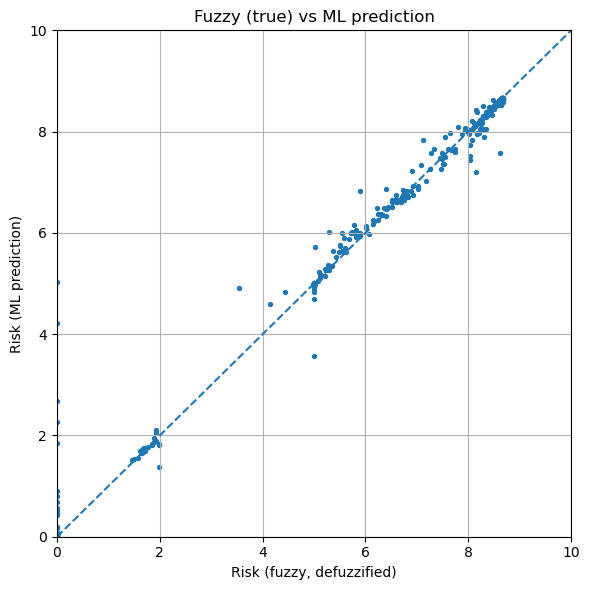

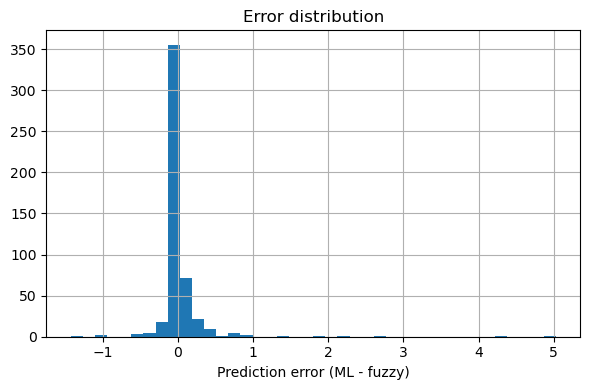

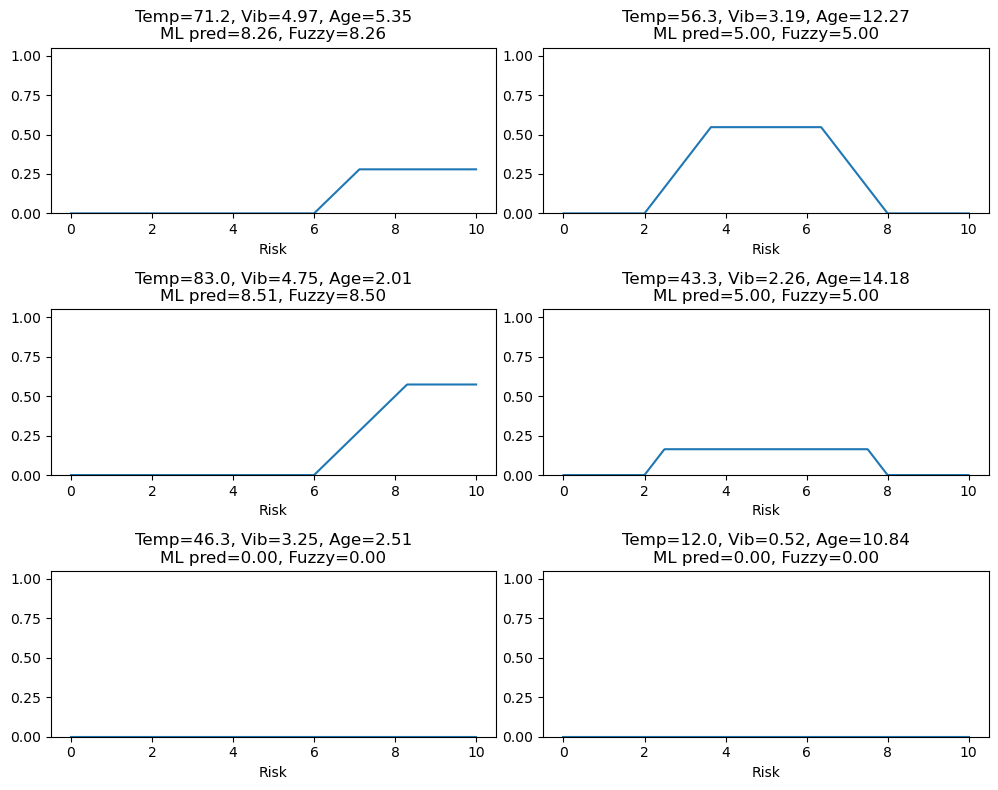

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=8)
plt.plot([0,10],[0,10], linestyle='--')
plt.xlabel('Risk (fuzzy, defuzzified)')
plt.ylabel('Risk (ML prediction)')
plt.title('Fuzzy (true) vs ML prediction')
plt.xlim(0,10)
plt.ylim(0,10)
plt.grid(True)
plt.tight_layout()
scatter_path = os.path.join('output', 'scatter_fuzzy_vs_ml.png')
plt.savefig(scatter_path)
print(f"Saved scatter plot: {scatter_path}")

errors = y_pred - y_test
plt.figure(figsize=(6,4))
plt.hist(errors, bins=40)
plt.xlabel('Prediction error (ML - fuzzy)')
plt.title('Error distribution')
plt.grid(True)
hist_path = os.path.join('output', 'error_histogram.png')
plt.tight_layout()
plt.savefig(hist_path)
print(f"Saved error histogram: {hist_path}")

sample_indices = rng.choice(len(X_test), 6, replace=False)
plt.figure(figsize=(10,8))
for i, idx in enumerate(sample_indices, 1):
    t, v, a = X_test[idx]
    c, det = fuzzy_inference_single(t, v, a, debug=True)
    plt.subplot(3,2,i)
    plt.plot(risk_x, det['agg'])
    plt.title(f"Temp={t:.1f}, Vib={v:.2f}, Age={a:.2f}\nML pred={y_pred[idx]:.2f}, Fuzzy={y_test[idx]:.2f}")
    plt.xlabel('Risk')
    plt.ylim(0,1.05)
plt.tight_layout()
agg_path = os.path.join('output', 'example_aggs.png')
plt.savefig(agg_path)
print(f"Saved example aggregations: {agg_path}")

print('\nRésumé:')
print(f" - RMSE = {rmse:.4f}")
print(f" - R2   = {r2:.4f}")
print("Interprétation rapide:")
print(" - La logique floue donne un système explicable.\n - Le modèle ML reproduit fidèlement le comportement du système flou (faible RMSE, R2 proche de 1).")

print('\nFin du script.')
